In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, ListedColormap
import matplotlib.colorbar as colorbar
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider
import matplotlib.animation as animation
import matplotlib as mat
import os
import os.path as op
from matplotlib import font_manager as fm
import seaborn as sns
# import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from scipy.stats import rayleigh, norm
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KernelDensity
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.signal import savgol_filter
from peregrin.scripts import PlotParams, FilesAndFolders
from itertools import combinations
from scipy.stats import mannwhitneyu
import plotly.express as px
import plotly.graph_objects as go

# import fitz
import altair as alt


from scipy.stats import gaussian_kde
from matplotlib.patches import Polygon
from superviolin.plot import Superviolin

In [86]:
# Silencing harmless warnings - FutureWarning and DeprecationWarning

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [87]:
input_file1 = r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\2025_04_03 NEU_Hoechst_FaDu1_DAPI_s2_spots.csv"

input_files = [input_file1]
parsed_input = [input_files]

In [88]:
microns_per_pixel = 0.65  # SIMONA

xy_min, xy_max = 0, (1024 * microns_per_pixel)
aspect_ratio = xy_max / xy_max  # Square aspect ratio for SIMONA

In [89]:
# Function to try converting a string to a numeric type (int or float)

def try_convert_numeric(x):
    try:
        # Only process strings
        if isinstance(x, str):
            x_stripped = x.strip()
            num = float(x_stripped)
            if num.is_integer():
                return int(num)
            else:
                return num
        else:
            return x
    except ValueError:
        return x

In [90]:
def GetDataFrame(filepath: str) -> pd.DataFrame:
        """
        Loads a DataFrame from a file based on its extension.
        Supported formats: CSV, Excel, Feather, Parquet, HDF5, JSON.
        """
        _, ext = op.splitext(filepath.lower())

        try:
            if ext == '.csv':
                return pd.read_csv(filepath)
            elif ext in ['.xls', '.xlsx']:
                return pd.read_excel(filepath)
            elif ext == '.feather':
                return pd.read_feather(filepath)
            elif ext == '.parquet':
                return pd.read_parquet(filepath)
            elif ext in ['.h5', '.hdf5']:
                return pd.read_hdf(filepath)
            elif ext == '.json':
                return pd.read_json(filepath)
            else:
                raise ValueError(f"{ext} is not a supported file format.")
        except Exception as e:
            raise RuntimeError(f"Failed to load file '{filepath}': {e}")

In [91]:
def Extract(df: pd.DataFrame, id_col: str, t_col: str, x_col: str, y_col: str, mirror_y: bool = True) -> pd.DataFrame:
        # Keep only relevant columns and convert to numeric
        df = df[[id_col, t_col, x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()

        # Mirror Y if needed
        if mirror_y:
            """
            TrackMate may export y-coordinates mirrored.
            This does not affect statistics but leads to incorrect visualization.
            Here Y data is reflected across its midpoint for accurate directionality.
            """
            y_mid = (df[y_col].min() + df[y_col].max()) / 2
            df[y_col] = 2 * y_mid - df[y_col]

        # Standardize column names
        return df.rename(columns={id_col: 'Track ID', t_col: 'Time point', x_col: 'X coordinate', y_col: 'Y coordinate'})


In [92]:
def Spots(df: pd.DataFrame) -> pd.DataFrame:

        """
        Compute per-frame tracking metrics for each cell track in the DataFrame:
        - Distance: Euclidean distance between consecutive positions
        - Direction (rad): direction of travel in radians
        - Track length: cumulative distance along the track
        - Net distance: straight-line distance from track start
        - Confinement ratio: Net distance / Track length

        Expects columns: Condition, Replicate, Track ID, X coordinate, Y coordinate, Time point
        Returns a DataFrame sorted by Condition, Replicate, Track ID, Time point with new metric columns.
        """
        if df.empty:
            return df.copy()

        df.sort_values(by=['Condition', 'Replicate', 'Track ID', 'Time point'], inplace=True)

        # Sort and work on a copy
        # df = df.sort_values(['Condition', 'Replicate', 'Track ID', 'Time point']).copy()
        grp = df.groupby(['Condition', 'Replicate', 'Track ID'], sort=False)

        # Distance between current and next position
        df['Distance'] = np.sqrt(
            (grp['X coordinate'].shift(-1) - df['X coordinate'])**2 +
            (grp['Y coordinate'].shift(-1) - df['Y coordinate'])**2
            ).fillna(0)

        # Direction of travel (radians) based on diff to previous point
        df['Direction (rad)'] = np.arctan2(
            grp['Y coordinate'].diff(),
            grp['X coordinate'].diff()
            ).fillna(0)

        # Cumulative track length
        df['Track length'] = grp['Distance'].cumsum()

        # Net (straight-line) distance from the start of the track
        start = grp[['X coordinate', 'Y coordinate']].transform('first')
        df['Net distance'] = np.sqrt(
            (df['X coordinate'] - start['X coordinate'])**2 +
            (df['Y coordinate'] - start['Y coordinate'])**2
            )

        # Confinement ratio: net distance vs. actual path length
        # Avoid division by zero by replacing zeros with NaN, then fill
        df['Confinement ratio'] = (df['Net distance'] / df['Track length'].replace(0, np.nan)).fillna(0)

        return df


def Tracks(df: pd.DataFrame) -> pd.DataFrame:
        """
        Compute comprehensive track-level metrics for each cell track in the DataFrame, including:
        - Track length: sum of Distance
        - Net distance: straight-line from first to last position
        - Confinement ratio: Net distance / Track length
        - Min speed, Max speed, Mean speed, Std speed, Median speed (per-track on Distance)
        - Mean direction (rad/deg), Std deviation (rad/deg), Median direction (rad/deg) (circular stats)

        Expects columns: Condition, Replicate, Track ID, Distance, X coordinate, Y coordinate, Direction (rad)
        Returns a single DataFrame indexed by Condition, Replicate, Track ID with all metrics.
        """
        if df.empty:
            cols = [
                'Condition','Replicate','Track ID',
                'Track length','Net distance','Confinement ratio',
                'Speed min','Speed max','Speed mean','Speed std','Speed median',
                'Direction mean (rad)','Direction std (rad)','Direction median (rad)',
                'Direction mean (deg)','Direction std (deg)','Direction median (deg)'
            ]
            return pd.DataFrame(columns=cols)

        # Group by track
        grp = df.groupby(['Condition','Replicate','Track ID'], sort=False)

        agg = grp.agg(
            **{
                'Track length': ('Distance', 'sum'),
                'Speed min':   ('Distance', 'min'),
                'Speed max':   ('Distance', 'max'),
                'Speed mean':  ('Distance', 'mean'),
                'Speed std':   ('Distance', 'std'),
                'Speed median':('Distance', 'median'),
                'start_x':     ('X coordinate', 'first'),
                'end_x':       ('X coordinate', 'last'),
                'start_y':     ('Y coordinate', 'first'),
                'end_y':       ('Y coordinate', 'last')
            }
        )

        # Compute net displacement and confinement ratio
        agg['Net distance'] = np.hypot(agg['end_x'] - agg['start_x'], agg['end_y'] - agg['start_y'])
        agg['Confinement ratio'] = (agg['Net distance'] / agg['Track length'].replace(0, np.nan)).fillna(0)
        agg = agg.drop(columns=['start_x','end_x','start_y','end_y'])

        # Circular direction statistics: need sin & cos per observation
        sin_cos = df.assign(_sin=np.sin(df['Direction (rad)']), _cos=np.cos(df['Direction (rad)']))
        dir_agg = sin_cos.groupby(['Condition','Replicate','Track ID'], sort=False).agg(
            mean_sin=('_sin','mean'), mean_cos=('_cos','mean'),
            median_sin=('_sin','median'), median_cos=('_cos','median')
        )
        # derive circular metrics
        dir_agg['Direction mean (rad)'] = np.arctan2(dir_agg['mean_sin'], dir_agg['mean_cos'])
        dir_agg['Direction std (rad)'] = np.hypot(dir_agg['mean_sin'], dir_agg['mean_cos'])
        dir_agg['Direction median (rad)'] = np.arctan2(dir_agg['median_sin'], dir_agg['median_cos'])
        dir_agg['Direction mean (deg)'] = np.degrees(dir_agg['Direction mean (rad)']) % 360
        dir_agg['Direction std (deg)'] = np.degrees(dir_agg['Direction std (rad)']) % 360
        dir_agg['Direction median (deg)'] = np.degrees(dir_agg['Direction median (rad)']) % 360
        dir_agg = dir_agg.drop(columns=['mean_sin','mean_cos','median_sin','median_cos'])

            # Count points per track
        # number of rows (frames) per track
        point_counts = grp.size().rename('Track points')

        # Merge all metrics into one DataFrame
        result = agg.merge(dir_agg, left_index=True, right_index=True)
        # Merge point counts
        result = result.merge(point_counts, left_index=True, right_index=True)
        result = result.reset_index()
        return result


def Time(df: pd.DataFrame) -> pd.DataFrame:
        """
        Compute per-frame (time point) summary metrics grouped by Condition, Replicate, Time point:
        - Track length, Net distance, Confinement ratio distributions: min, max, mean, std, median
        - Speed (Distance) distributions as Speed min, Speed max, Speed mean, Speed std, Speed median
        - Direction (rad) distributions (circular): Direction mean (rad), Direction std (rad), Direction median (rad)
            and corresponding degrees

        Expects columns: Condition, Replicate, Time point, Track length, Net distance,
                        Confinement ratio, Distance, Direction (rad)
        Returns a DataFrame indexed by Condition, Replicate, Time point with all time-point metrics.
        """
        if df.empty:
            # define columns
            cols = ['Condition','Replicate','Time point'] + \
                [f'{metric} {stat}' for metric in ['Track length','Net distance','Confinement ratio'] for stat in ['min','max','mean','std','median']] + \
                [f'Speed {stat}' for stat in ['min','max','mean','std','median']] + \
                ['Direction mean (rad)','Direction std (rad)','Direction median (rad)',
                    'Direction mean (deg)','Direction std (deg)','Direction median (deg)']
            return pd.DataFrame(columns=cols)

        group_cols = ['Condition','Replicate','Time point']

        # 1) stats on track metrics per frame
        metrics = ['Track length','Net distance','Confinement ratio']
        agg_funcs = ['min','max','mean','std','median']
        # build agg dict
        agg_dict = {m: agg_funcs for m in metrics}
        frame_agg = df.groupby(group_cols).agg(agg_dict)
        # flatten columns
        frame_agg.columns = [f'{metric} {stat}' for metric, stat in frame_agg.columns]

        # 2) speed stats (Distance distributions)
        speed_agg = df.groupby(group_cols)['Distance'].agg(['min','max','mean','std','median'])
        speed_agg.columns = [f'Speed {stat}' for stat in speed_agg.columns]

        # 3) circular direction stats per frame
        # compute sin/cos columns
        tmp = df.assign(_sin=np.sin(df['Direction (rad)']), _cos=np.cos(df['Direction (rad)']))
        dir_frame = tmp.groupby(group_cols).agg({'_sin':'mean','_cos':'mean','Direction (rad)':'count'})
        # mean direction
        dir_frame['Direction mean (rad)'] = np.arctan2(dir_frame['_sin'], dir_frame['_cos'])
        # circular std: R = sqrt(mean_sin^2+mean_cos^2)
        dir_frame['Direction std (rad)'] = np.hypot(dir_frame['_sin'], dir_frame['_cos'])
        # median direction: use groupby apply median sin/cos
        median = tmp.groupby(group_cols).agg({'_sin':'median','_cos':'median'})
        dir_frame['Direction median (rad)'] = np.arctan2(median['_sin'], median['_cos'])
        # degrees
        dir_frame['Direction mean (deg)'] = np.degrees(dir_frame['Direction mean (rad)']) % 360
        dir_frame['Direction std (deg)'] = np.degrees(dir_frame['Direction std (rad)']) % 360
        dir_frame['Direction median (deg)'] = np.degrees(dir_frame['Direction median (rad)']) % 360
        dir_frame = dir_frame.drop(columns=['_sin','_cos','Direction (rad)'], errors='ignore')

        # merge all
        time_stats = frame_agg.merge(speed_agg, left_index=True, right_index=True)
        time_stats = time_stats.merge(dir_frame, left_index=True, right_index=True)
        time_stats = time_stats.reset_index()

        return time_stats


In [93]:
def parsed_files():


    df = GetDataFrame(input_file1)
    extracted = Extract(
        df,
        id_col="TRACK_ID",
        t_col="POSITION_T",
        x_col="POSITION_X",
        y_col="POSITION_Y",
        mirror_y=True,
    )

    # Assign condition label and replicate number
    extracted["Condition"] = 1
    extracted["Replicate"] = 1

        
    rawdata = extracted
    spot_stats = Spots(rawdata)
    rawspotstats = spot_stats
    rawtrackstats = Tracks(spot_stats)
    rawtimestats = Time(spot_stats)
    return rawdata, rawspotstats, rawtrackstats, rawtimestats
        
rawdata, rawspotstats, rawtrackstats, rawtimestats = parsed_files()

In [94]:
display(rawdata)

,Track ID,Time point,X coordinate,Y coordinate,Condition,Replicate,Distance,Direction (rad),Track length,Net distance,Confinement ratio
3,0.0,0.0,446.736280,156.054491,1,1,3.216652,0.000000,3.216652,0.000000,0.000000
71,0.0,1.0,447.634285,159.143251,1,1,1.233984,1.287863,4.450636,3.216652,0.722740
46,0.0,2.0,448.219978,158.057121,1,1,6.084747,-1.076246,10.535383,2.492366,0.236571
23,0.0,3.0,450.739419,152.518478,1,1,8.250066,-1.143888,18.785449,5.341209,0.284327
32,0.0,4.0,448.370468,144.615842,1,1,10.271566,-1.862040,29.057015,11.554794,0.397659
...,...,...,...,...,...,...,...,...,...,...,...
16224,202.0,89.0,114.447499,38.198918,1,1,15.135549,0.916256,55.813670,40.590509,0.727250
16225,202.0,90.0,126.049922,47.918415,1,1,0.000000,0.697317,55.813670,55.375750,0.992154
16229,203.0,88.0,0.000000,350.350000,1,1,7.150000,0.000000,7.150000,0.000000,0.000000
16230,203.0,89.0,0.000000,357.500000,1,1,6.550927,1.570796,13.700927,7.150000,0.521862


In [95]:
display(rawspotstats)

,Track ID,Time point,X coordinate,Y coordinate,Condition,Replicate,Distance,Direction (rad),Track length,Net distance,Confinement ratio
3,0.0,0.0,446.736280,156.054491,1,1,3.216652,0.000000,3.216652,0.000000,0.000000
71,0.0,1.0,447.634285,159.143251,1,1,1.233984,1.287863,4.450636,3.216652,0.722740
46,0.0,2.0,448.219978,158.057121,1,1,6.084747,-1.076246,10.535383,2.492366,0.236571
23,0.0,3.0,450.739419,152.518478,1,1,8.250066,-1.143888,18.785449,5.341209,0.284327
32,0.0,4.0,448.370468,144.615842,1,1,10.271566,-1.862040,29.057015,11.554794,0.397659
...,...,...,...,...,...,...,...,...,...,...,...
16224,202.0,89.0,114.447499,38.198918,1,1,15.135549,0.916256,55.813670,40.590509,0.727250
16225,202.0,90.0,126.049922,47.918415,1,1,0.000000,0.697317,55.813670,55.375750,0.992154
16229,203.0,88.0,0.000000,350.350000,1,1,7.150000,0.000000,7.150000,0.000000,0.000000
16230,203.0,89.0,0.000000,357.500000,1,1,6.550927,1.570796,13.700927,7.150000,0.521862


In [96]:
display(rawtrackstats)

,Condition,Replicate,Track ID,Track length,Speed min,Speed max,Speed mean,Speed std,Speed median,Net distance,Confinement ratio,Direction mean (rad),Direction std (rad),Direction median (rad),Direction mean (deg),Direction std (deg),Direction median (deg),Track points
0,1,1,0.0,109.935626,0.0,10.271566,1.208084,2.033823,0.370549,23.753319,0.216066,-1.444130,0.135784,-1.441469,277.257443,7.779827,277.409892,91
1,1,1,1.0,31.324713,0.0,3.974868,0.344228,0.469387,0.240656,3.826156,0.122145,-1.554603,0.110958,-1.611730,270.927804,6.357430,267.654659,91
2,1,1,2.0,169.048530,0.0,10.866875,6.761941,3.156550,7.551543,81.895564,0.484450,-3.040799,0.309414,3.141593,185.775036,17.728131,180.000000,25
3,1,1,3.0,57.342090,0.0,6.182416,0.630133,1.007957,0.268888,9.709825,0.169332,-1.053216,0.158131,-1.148985,299.655157,9.060214,294.168021,91
4,1,1,4.0,92.962005,0.0,7.876729,1.021560,1.933282,0.272708,26.553893,0.285642,0.419997,0.090203,0.059325,24.064063,5.168231,3.399087,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1,1,199.0,82.360232,0.0,13.852546,10.295029,4.403105,10.989902,82.150633,0.997455,0.833696,0.951960,0.898531,47.767273,54.543314,51.482056,8
200,1,1,200.0,52.389249,0.0,10.230959,5.821028,3.322296,7.013348,50.935875,0.972258,0.560946,0.952318,0.603147,32.139819,54.563802,34.557758,9
201,1,1,201.0,43.612977,0.0,9.996594,7.268830,3.758744,8.597843,43.486321,0.997096,0.728480,0.947826,0.836503,41.738845,54.306413,47.928097,6
202,1,1,202.0,55.813670,0.0,15.135549,11.162734,6.277449,13.549363,55.375750,0.992154,0.719977,0.933273,0.891664,41.251647,53.472629,51.088604,5


In [97]:
display(rawtimestats)

,Condition,Replicate,Time point,Track length min,Track length max,Track length mean,Track length std,Track length median,Net distance min,Net distance max,...,Speed max,Speed mean,Speed std,Speed median,Direction mean (rad),Direction std (rad),Direction median (rad),Direction mean (deg),Direction std (deg),Direction median (deg)
0,1,1,0.0,0.158489,11.519377,3.135597,1.793498,2.866978,0.000000,0.000000,...,11.519377,3.135597,1.793498,2.866978,0.000000,1.000000,0.000000,0.000000,57.295780,0.000000
1,1,1,1.0,0.880481,21.140823,6.184020,3.884197,5.079474,0.000000,11.519377,...,15.625777,3.068144,2.748848,2.220834,0.183781,0.665155,0.264682,10.529877,38.110582,15.165160
2,1,1,2.0,0.000000,36.593922,9.241347,6.141147,7.571922,0.000000,18.961276,...,16.434818,3.245864,3.118400,2.118306,-0.103413,0.282803,-0.005504,354.074883,16.203400,359.684640
3,1,1,3.0,0.000000,43.363633,12.195051,7.860568,9.770898,0.000000,32.302118,...,16.158748,3.060265,2.969032,2.160183,-0.802217,0.238064,-0.870160,314.036361,13.640070,310.143525
4,1,1,4.0,0.650000,56.806514,15.421803,9.995245,12.703153,0.000000,38.005165,...,13.442881,3.300661,3.080665,2.207317,-2.122509,0.053355,-2.064387,238.389191,3.056997,241.719315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1,1,86.0,13.521047,420.871667,89.230909,54.130512,78.540313,0.000000,310.845066,...,15.086673,0.824416,2.294769,0.222632,-2.955700,0.741225,-2.930794,190.650856,42.469087,192.077901
87,1,1,87.0,16.664679,433.352943,90.371283,54.737246,81.431069,1.102680,320.054049,...,14.102973,0.956654,2.310192,0.355718,-1.191287,0.801611,-1.336428,291.744266,45.928938,283.428316
88,1,1,88.0,7.150000,447.126595,90.624177,55.595165,81.390015,0.000000,331.323327,...,13.852546,0.736163,2.295021,0.097150,1.607129,0.888888,1.665645,92.081704,50.929559,95.434454
89,1,1,89.0,13.700927,460.883864,91.568941,56.477006,82.072192,1.026254,344.227296,...,15.135549,0.775219,2.347465,0.117075,-1.174064,0.645151,-1.319247,292.731074,36.964452,284.412709


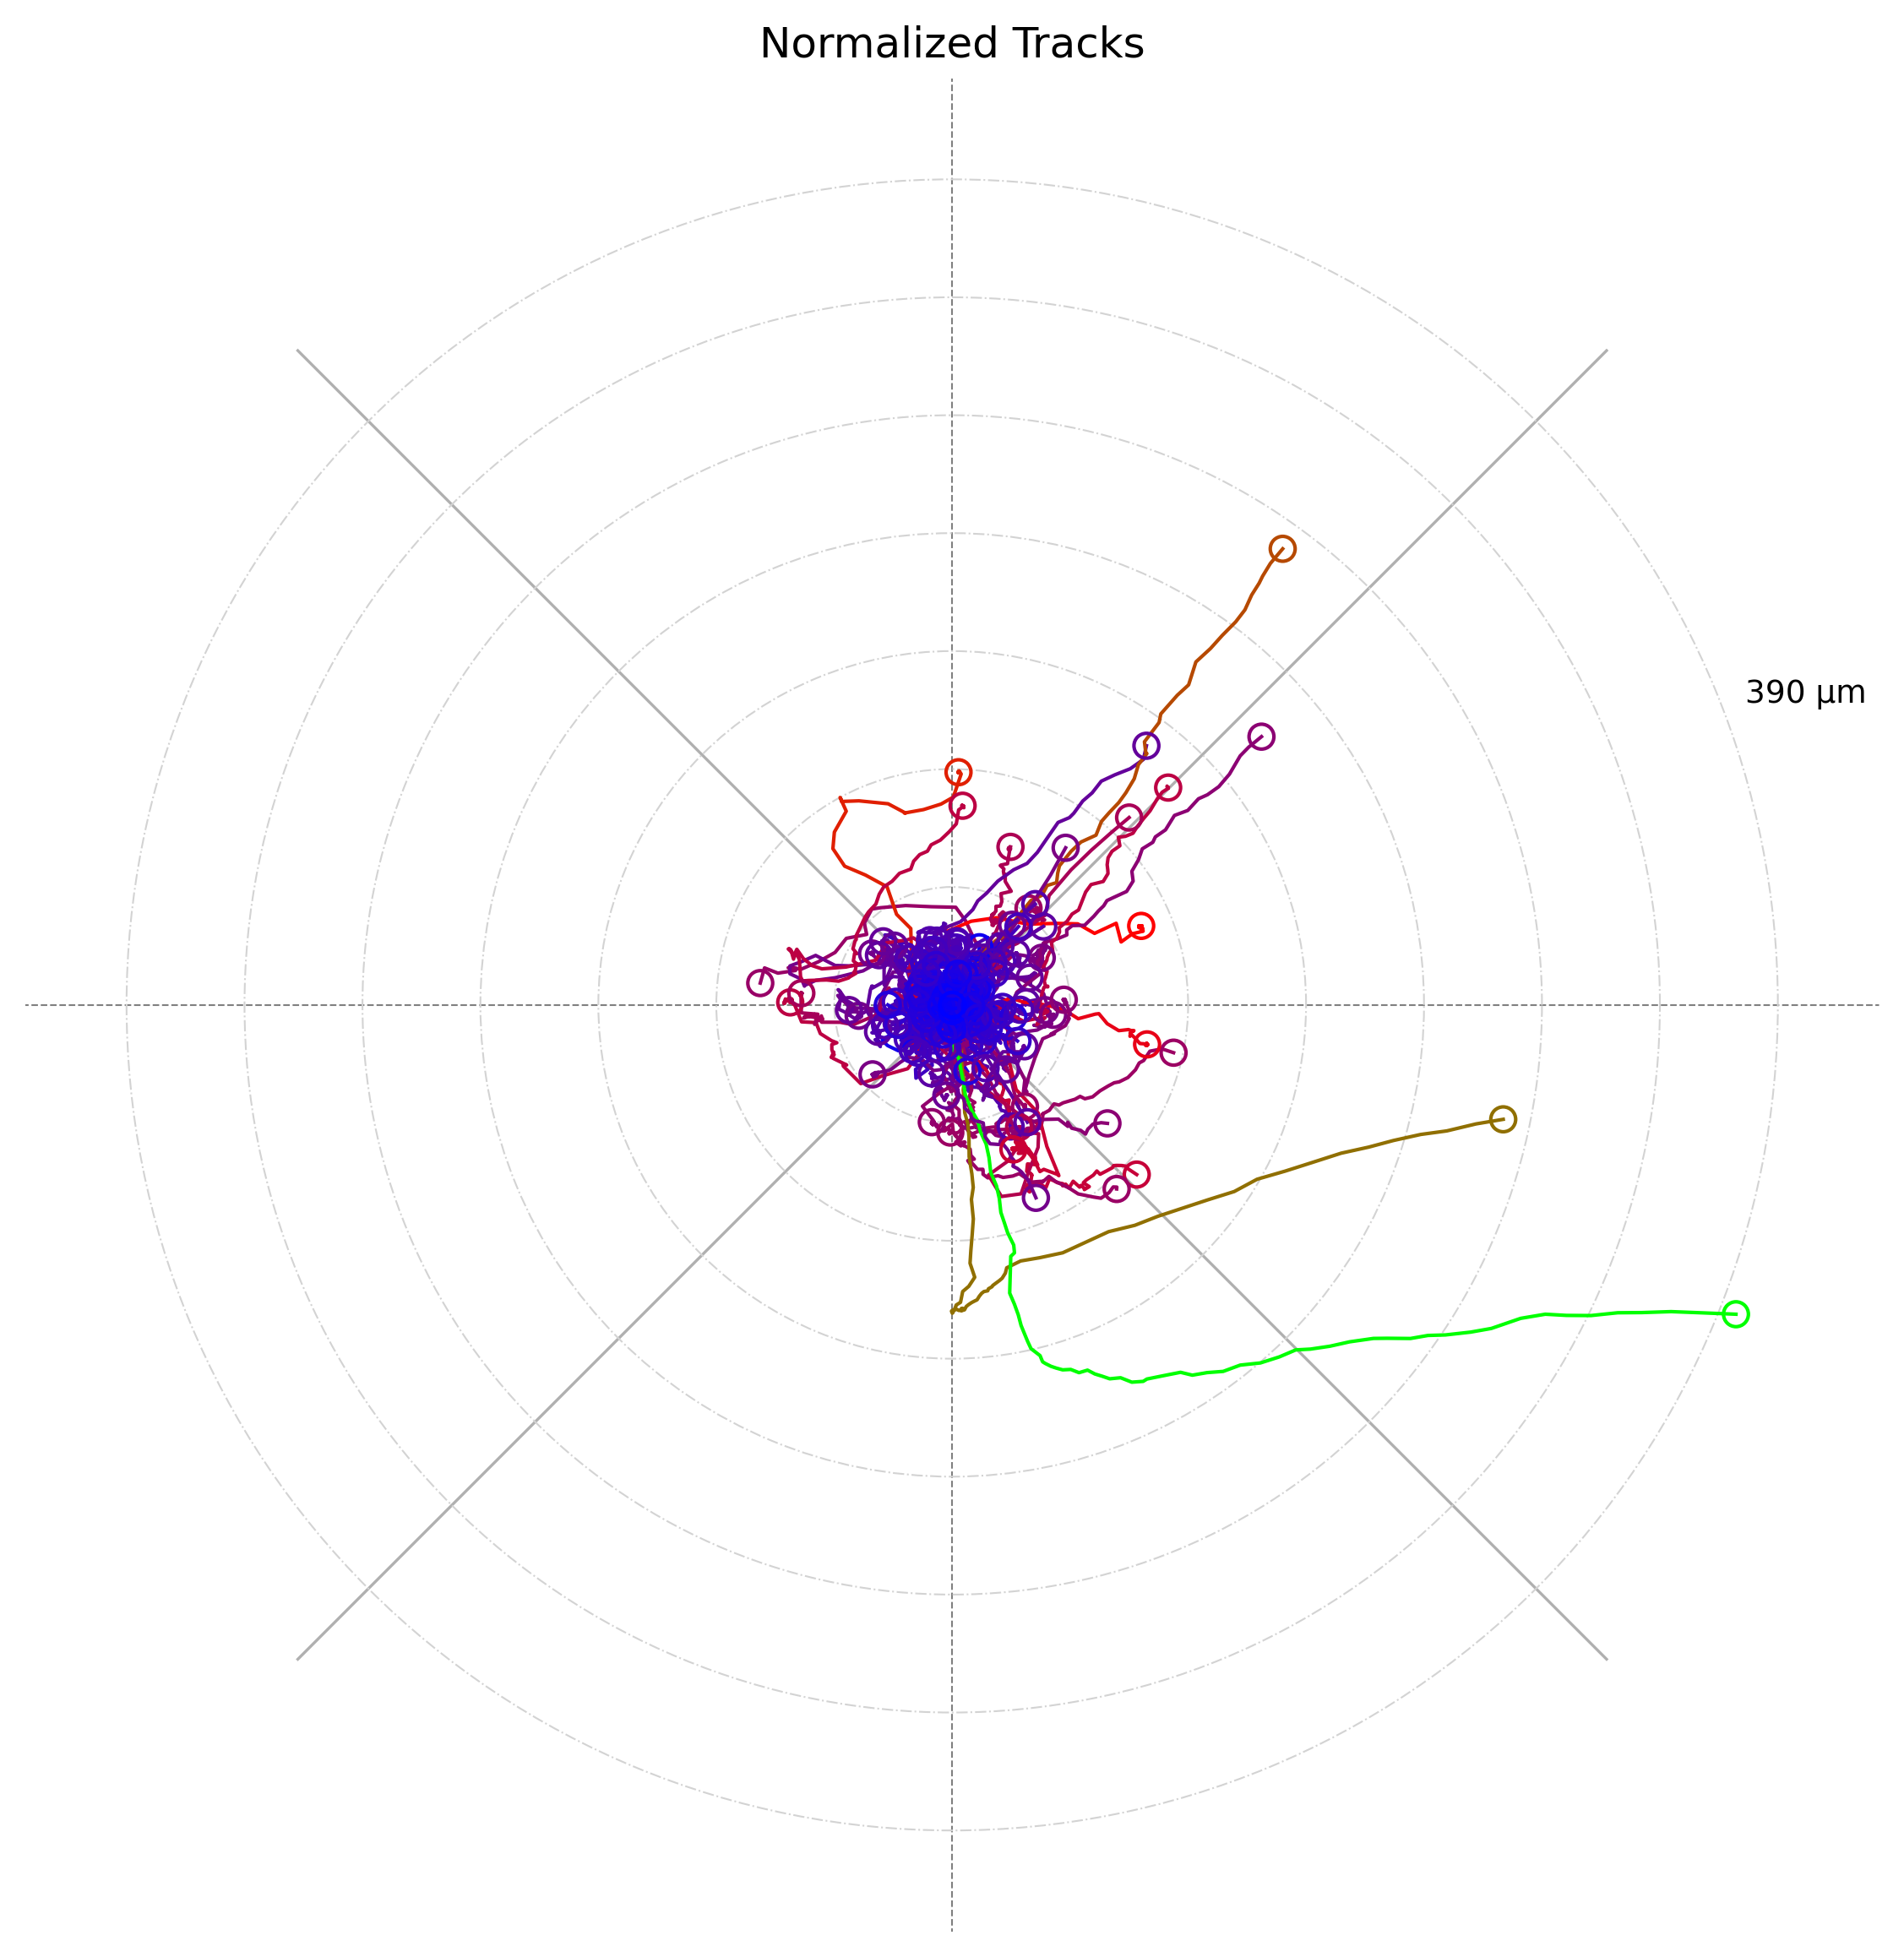

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_colormap(c_mode):
    if c_mode == 'greyscale':
        return plt.cm.gist_yarg
    elif c_mode == 'jet':
        return plt.cm.jet
    elif c_mode == 'brg':
        return plt.cm.brg
    elif c_mode == 'hot':
        return plt.cm.hot
    elif c_mode == 'gnuplot':
        return plt.cm.gnuplot
    elif c_mode == 'viridis':
        return plt.cm.viridis
    elif c_mode == 'rainbow':
        return plt.cm.rainbow
    elif c_mode == 'turbo':
        return plt.cm.turbo
    elif c_mode == 'nipy_spectral':
        return plt.cm.nipy_spectral
    elif c_mode == 'gist_ncar':
        return plt.cm.gist_ncar
    else:
        return None

def generate_random_color():
    r = np.random.randint(0, 255)
    g = np.random.randint(0, 255)
    b = np.random.randint(0, 255)
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

def generate_random_grey():
    n = np.random.randint(0, 240)
    return '#{:02x}{:02x}{:02x}'.format(n, n, n)

def visualize_normalized_tracks(
    df: pd.DataFrame, 
    condition: str, 
    replicate: str, 
    c_mode: str, 
    only_one_color: str, 
    lw: float, 
    grid: bool, 
    backround: str, 
    lut_metric: str, 
    placement: int,
    end_marker_mode: str = 'circle',   # 'circle', 'arrow', or None
    marker_size: float = 80,           # Size of circle marker
    arrow_width: float = 0.022         # Width/thickness of arrow tip
):
    if condition is not None and replicate is not None:
        try:
            condition = int(condition)
        except (ValueError, TypeError):
            pass
        try:
            replicate = int(replicate)
        except (ValueError, TypeError):
            pass

    if condition == 'all':
        df = df.sort_values(by=['Condition', 'Replicate', 'Track ID', 'Time point'])
    elif condition != 'all' and replicate == 'all':
        df = df[df['Condition'] == condition].sort_values(by=['Condition', 'Replicate', 'Track ID', 'Time point'])
    elif condition != 'all' and replicate != 'all':
        df = df[(df['Condition'] == condition) & (df['Replicate'] == replicate)].sort_values(by=['Condition', 'Replicate', 'Track ID', 'Time point'])

    grouped = df.groupby(['Condition', 'Replicate', 'Track ID'])
    unique_tracks = df[['Condition', 'Replicate', 'Track ID']].drop_duplicates().reset_index(drop=True)

    if c_mode == 'random colors':
        track_colors = [generate_random_color() for _ in range(len(unique_tracks))]
    elif c_mode == 'random greys':
        track_colors = [generate_random_grey() for _ in range(len(unique_tracks))]
    else:
        track_colors = [None] * len(unique_tracks)
    color_map_direct = dict(zip(unique_tracks['Track ID'], track_colors))
    df['Color'] = df['Track ID'].map(color_map_direct)
    
    for (cond, repl, track_id), group in grouped:
        start_x = group['X coordinate'].iloc[0]
        start_y = group['Y coordinate'].iloc[0]
        df.loc[group.index, 'X coordinate'] -= start_x
        df.loc[group.index, 'Y coordinate'] -= start_y

    df['r'] = np.sqrt(df['X coordinate']**2 + df['Y coordinate']**2)
    df['theta'] = np.arctan2(df['Y coordinate'], df['X coordinate'])

    fig, ax = plt.subplots(figsize=(12.5, 9.5), subplot_kw={'projection': 'polar'})
    y_max = df['r'].max() * 1.1

    ax.set_title('Normalized Tracks')
    ax.set_ylim(0, y_max)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.grid(grid)
    
    if c_mode not in ['random colors', 'random greys', 'only-one'] and lut_metric is not None:
        track_metric = df.groupby('Track ID')[lut_metric].mean()
        metric_min = track_metric.min()
        metric_max = track_metric.max()
    else:
        track_metric = None

    # Plot all tracks
    for (cond, repl, track_id), group in grouped:
        if c_mode == 'random colors':
            color = group['Color'].iloc[0]
        elif c_mode == 'random greys':
            color = group['Color'].iloc[0]
        elif c_mode == 'only-one':
            color = only_one_color
        else:
            colormap = get_colormap(c_mode)
            if colormap is not None and track_metric is not None:
                val = track_metric.get(track_id, 0)
                if metric_max > metric_min:
                    norm_val = (val - metric_min) / (metric_max - metric_min)
                else:
                    norm_val = 0.5
                color = colormap(norm_val)
            else:
                color = 'black'

        # Plot the track
        ax.plot(group['theta'], group['r'], lw=lw, color=color, zorder=2)

        # --------- END MARKER OPTIONS ----------
        if end_marker_mode == 'circle':
            # Open circle at the end of the track
            ax.scatter(
                [group['theta'].iloc[-1]], [group['r'].iloc[-1]],
                facecolors='none', edgecolors=color, s=50, linewidths=lw, zorder=3
            )
        elif end_marker_mode == 'arrow':
            # Arrow tip only at the end (stubby)
            x = group['X coordinate'].values
            y = group['Y coordinate'].values
            mean_dx = x[-1] - x[0]
            mean_dy = y[-1] - y[0]
            mean_angle = np.arctan2(mean_dy, mean_dx)
            end_r = group['r'].iloc[-1] + 10.9  # Tiny "shaft"
            leg_length = y_max * 0.0000001  # Tiny "shaft"
            start_r = max(0, end_r - leg_length)
            ax.annotate(
                '',
                xy=(mean_angle, end_r),      # Arrow tip at track end
                xytext=(mean_angle, start_r),# Start just behind
                arrowprops=dict(
                    facecolor=color,
                    edgecolor=color,
                    arrowstyle='-|>',
                    lw=arrow_width*20,
                    mutation_scale=15
                ),
                zorder=4
            )
        # else: no marker

    if backround == 'light':
        x_grid_color = 'grey'
        y_grid_color = 'lightgrey'
        ax.set_facecolor('white')
    elif backround == 'dark':
        x_grid_color = 'lightgrey'
        y_grid_color = 'grey'
        ax.set_facecolor('darkgrey')

    for i, line in enumerate(ax.get_xgridlines()):
        if i % 2 == 0:
            line.set_linestyle('--')
            line.set_color(x_grid_color)
            line.set_linewidth(0.5)

    for line in ax.get_ygridlines():
        line.set_linestyle('-.')
        line.set_color(y_grid_color)
        line.set_linewidth(0.5)

    if placement == 1:
        ax.text(
            0.35, y_max * 0.98, 
            f'{int(round(y_max, -1))} µm',
            ha='center', va='center', fontsize=9, color='black'
        )
    elif placement == 2:
        ax.text(
            0, y_max * 1.1, 
            f'{int(round(y_max * 1.1, -1))} µm',
            ha='center', va='center', fontsize=9, color='black'
        )

    plt.show()


visualize_normalized_tracks(
    df=rawspotstats, 
    condition='all',
    replicate='all',
    c_mode='brg',
    only_one_color='black',
    lw=1.0,
    grid=True,
    backround='light',
    lut_metric='Net distance',
    placement=1,
    end_marker_mode='circle',   # Use 'circle' or 'arrow'
    marker_size=120
)


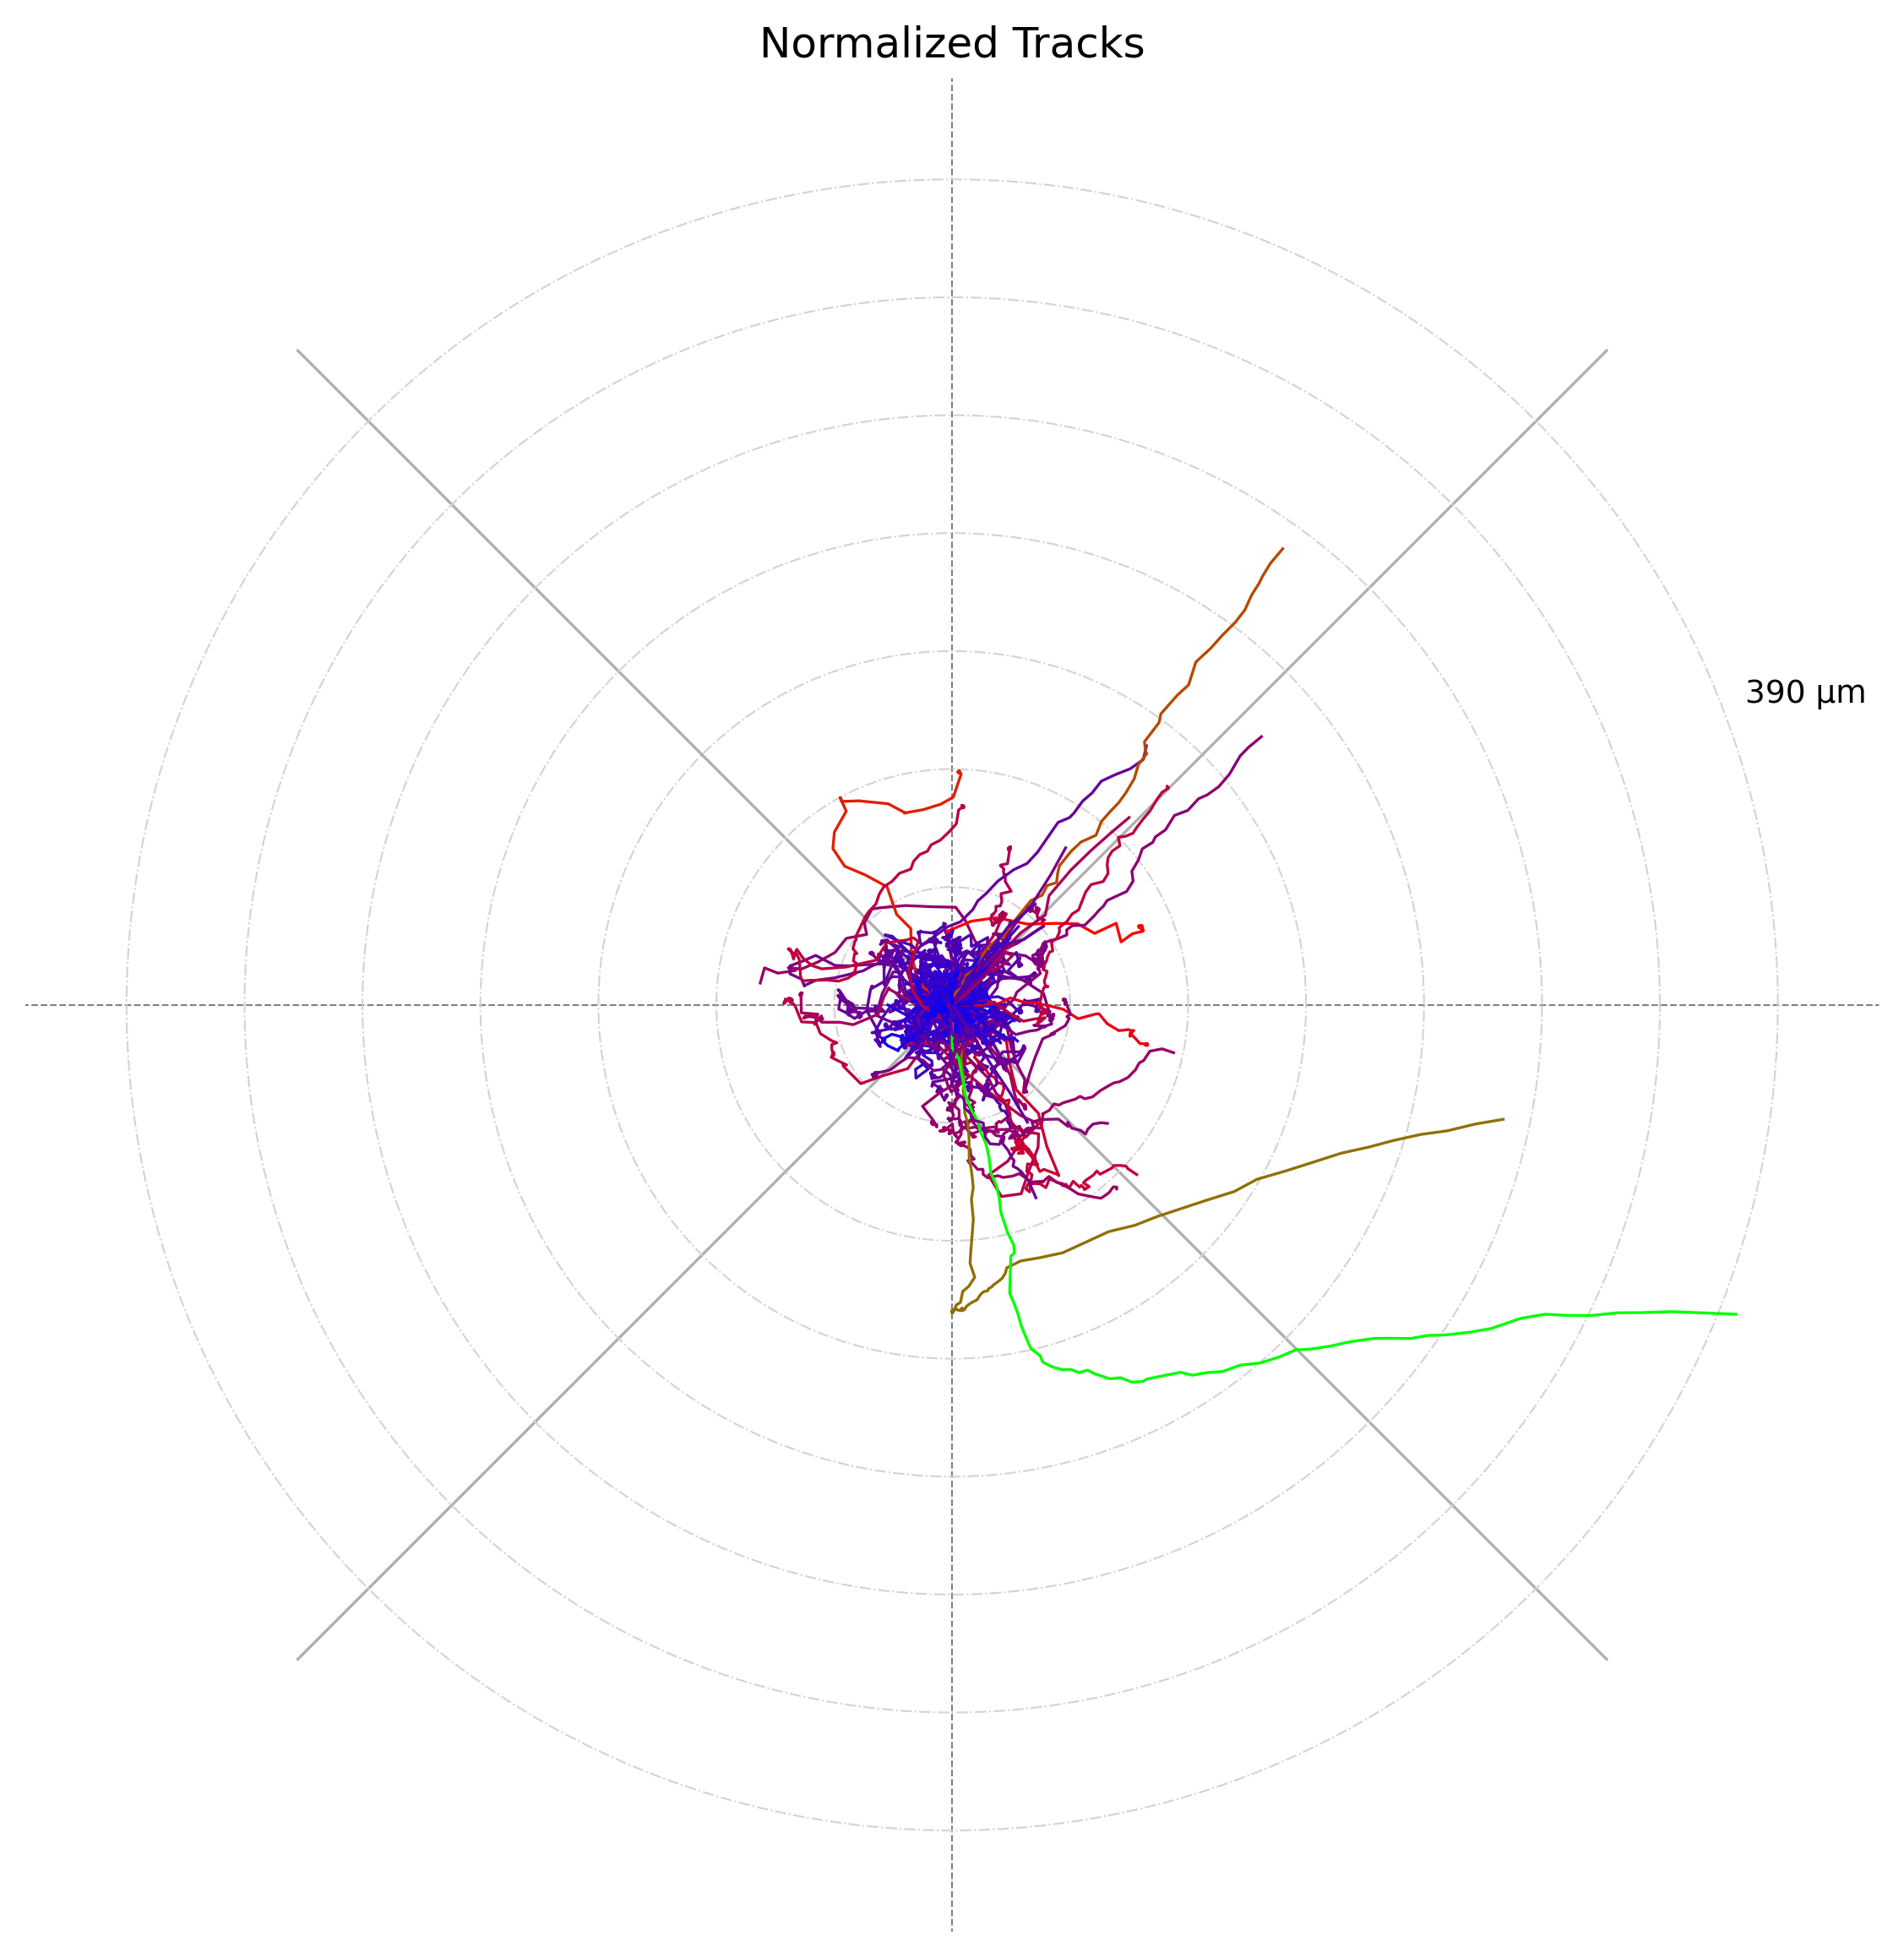

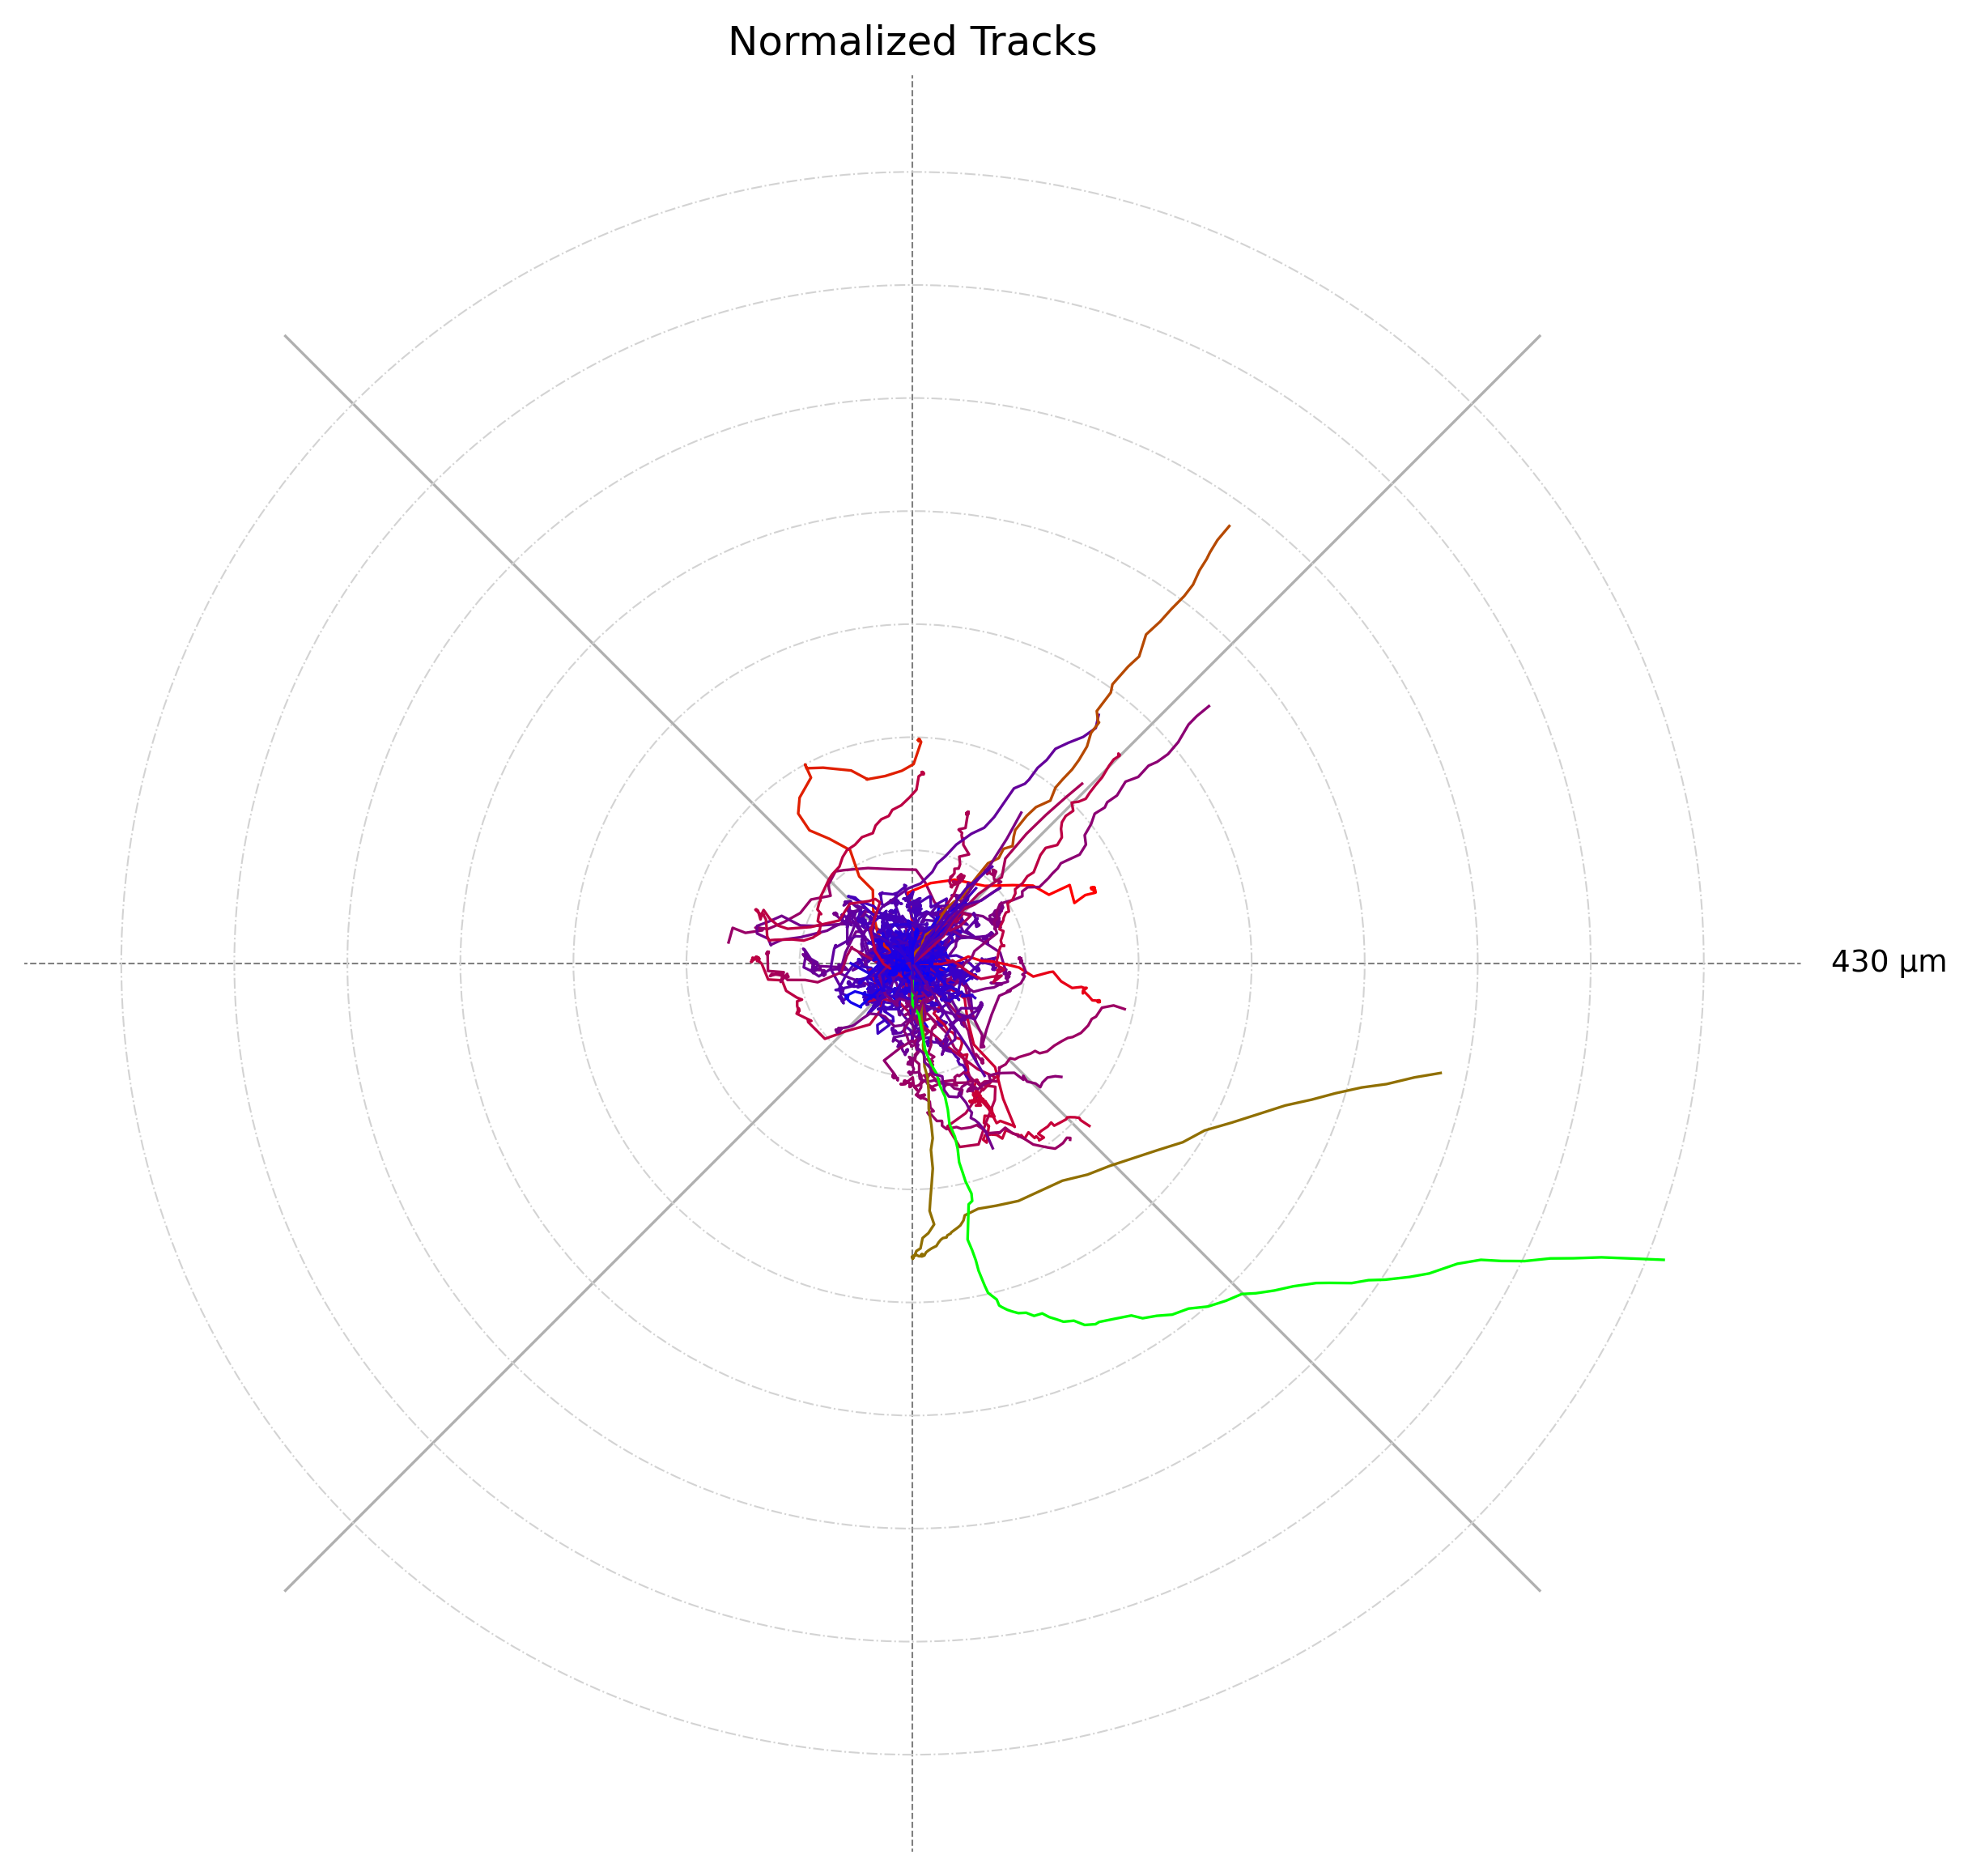

In [98]:
def get_colormap(c_mode):
    if c_mode == 'greyscale':
        return plt.cm.gist_yarg
    elif c_mode == 'jet':
        return plt.cm.jet
    elif c_mode == 'brg':
        return plt.cm.brg
    elif c_mode == 'hot':
        return plt.cm.hot
    elif c_mode == 'gnuplot':
        return plt.cm.gnuplot
    elif c_mode == 'viridis':
        return plt.cm.viridis
    elif c_mode == 'rainbow':
        return plt.cm.rainbow
    elif c_mode == 'turbo':
        return plt.cm.turbo
    elif c_mode == 'nipy_spectral':
        return plt.cm.nipy_spectral
    elif c_mode == 'gist_ncar':
        return plt.cm.gist_ncar
    else:
        return None


def generate_random_color():
    r = np.random.randint(0, 255)  # Random value for Red
    g = np.random.randint(0, 255)  # Random value for Green
    b = np.random.randint(0, 255)  # Random value for Blue
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)


def generate_random_grey():
    n = np.random.randint(0, 240)  # Random value for Grey
    return '#{:02x}{:02x}{:02x}'.format(n, n, n)




def visualize_normalized_tracks(df:pd.DataFrame, condition:str, replicate:str, c_mode:str, only_one_color:str, lw:float, grid:bool, backround:str, lut_metric:str, placement:int):

    if condition == None or replicate == None:
        pass
    else:
        try:
            condition = int(condition)
        except ValueError or TypeError:
            pass
        try:
            replicate = int(replicate)
        except ValueError or TypeError:
            pass

    if condition == 'all':
        df = df.sort_values(by=['Condition', 'Replicate', 'Track ID', 'Time point'])
    elif condition != 'all' and replicate == 'all':
        df = df[df['Condition'] == condition].sort_values(by=['Condition', 'Replicate', 'Track ID', 'Time point'])
    elif condition != 'all' and replicate != 'all':
        df = df[(df['Condition'] == condition) & (df['replicate'] == replicate)].sort_values(by=['Condition', 'Replicate', 'Track ID', 'Time point'])


    # First sort the data and get groups of tracks.
    grouped = df.groupby(['Condition', 'Replicate', 'Track ID'])
    
    unique_tracks = df[['Condition', 'Replicate', 'Track ID']].drop_duplicates().reset_index(drop=True)
    # For the random modes, pre-assign a color per track.
    if c_mode in ['random colors']:
        track_colors = [generate_random_color() for _ in range(len(unique_tracks))]
    elif c_mode in ['random greys']:
        track_colors = [generate_random_grey() for _ in range(len(unique_tracks))]
    else:
        track_colors = [None] * len(unique_tracks)  # Colors will be assigned via the LUT
    
    color_map_direct = dict(zip(unique_tracks['Track ID'], track_colors))
    df['Color'] = df['Track ID'].map(color_map_direct)
    
    # Normalize the positions for each track (shift tracks to start at 0,0)
    for (cond, repl, track_id), group in grouped:
        start_x = group['X coordinate'].iloc[0]
        start_y = group['Y coordinate'].iloc[0]
        df.loc[group.index, 'X coordinate'] -= start_x
        df.loc[group.index, 'Y coordinate'] -= start_y

    # Convert to polar coordinates.
    df['r'] = np.sqrt(df['X coordinate']**2 + df['Y coordinate']**2)
    df['theta'] = np.arctan2(df['Y coordinate'], df['X coordinate'])
    
    fig, ax = plt.subplots(figsize=(12.5, 9.5), subplot_kw={'projection': 'polar'})
    y_max = df['r'].max() * 1.1

    ax.set_title('Normalized Tracks')
    ax.set_ylim(0, y_max)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.grid(grid)
    
    # If using a colormap based on a LUT metric, pre-compute aggregated values
    # Here we use the mean of the lut_metric per track. You can adjust the aggregation as needed.
    if c_mode not in ['random colors', 'random greys', 'only-one'] and lut_metric is not None:
        track_metric = df.groupby('Track ID')[lut_metric].mean()
        metric_min = track_metric.min()
        metric_max = track_metric.max()
    else:
        track_metric = None

    # Plot all tracks
    for (cond, repl, track_id), group in grouped:
        # First, handle the modes that specify a direct color.
        if c_mode == 'random colors':
            color = group['Color'].iloc[0]
        elif c_mode == 'random greys':
            color = group['Color'].iloc[0]
        elif c_mode == 'only-one':
            color = only_one_color
        else:
            colormap = get_colormap(c_mode)

            # If no explicit color was assigned and we have a colormap, then use LUT mapping.
            if colormap is not None and track_metric is not None:
                # Get the aggregated metric value for the track.
                val = track_metric.get(track_id, 0)
                # Normalize to [0, 1] (protect against division by zero)
                if metric_max > metric_min:
                    norm_val = (val - metric_min) / (metric_max - metric_min)
                else:
                    norm_val = 0.5
                color = colormap(norm_val)
            else:
                # Fallback if something goes wrong
                color = 'black'

        # Plot the track using computed color.
        ax.plot(group['theta'], group['r'], lw=lw, color=color)
    
    if backround == 'light':
        x_grid_color = 'grey'
        y_grid_color = 'lightgrey'
        ax.set_facecolor('white')
    elif backround == 'dark':
        x_grid_color = 'lightgrey'
        y_grid_color = 'grey'
        ax.set_facecolor('darkgrey')

    # Style the polar grid.
    for i, line in enumerate(ax.get_xgridlines()):
        if i % 2 == 0:
            line.set_linestyle('--')
            line.set_color(x_grid_color)
            line.set_linewidth(0.5)

    for line in ax.get_ygridlines():
        line.set_linestyle('-.')
        line.set_color(y_grid_color)
        line.set_linewidth(0.5)


    if placement == 1:
        # Place the text at theta=0 (right side), higher above the max radius
        ax.text(
            0.35, y_max * 0.98, 
            f'{int(round(y_max, -1))} µm',
            ha='center', va='center', fontsize=9, color='black'
        )
    elif placement == 2:
        ax.text(
            0, y_max * 1.1, 
            f'{int(round(y_max * 1.1, -1))} µm',
            ha='center', va='center', fontsize=9, color='black'
        )


    # return plt.gcf()

# Example usage
visualize_normalized_tracks(
    rawspotstats,
    condition='all',
    replicate='all',
    c_mode='brg',
    only_one_color='black',
    lw=0.8,
    grid=True,
    backround='light',
    lut_metric='Net distance',
    placement=1
)

# Example usage
visualize_normalized_tracks(
    rawspotstats,
    condition='all',
    replicate='all',
    c_mode='brg',
    only_one_color='black',
    lw=0.8,
    grid=True,
    backround='light',
    lut_metric='Net distance',
    placement=2
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go

def _generate_random_color():
    r = np.random.randint(0, 255)
    g = np.random.randint(0, 255)
    b = np.random.randint(0, 255)
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

def _generate_random_grey():
    n = np.random.randint(0, 240)
    return '#{:02x}{:02x}{:02x}'.format(n, n, n)

def _get_cmap(c_mode):
    if c_mode == 'greyscale LUT':
        return plt.cm.gist_yarg
    elif c_mode == 'jet LUT':
        return plt.cm.jet
    elif c_mode == 'brg LUT' or c_mode == 'brg':  # Allow 'brg' for shorthand
        return plt.cm.brg
    elif c_mode == 'hot LUT':
        return plt.cm.hot
    elif c_mode == 'gnuplot LUT':
        return plt.cm.gnuplot
    elif c_mode == 'viridis LUT':
        return plt.cm.viridis
    elif c_mode == 'rainbow LUT':
        return plt.cm.rainbow
    elif c_mode == 'turbo LUT':
        return plt.cm.turbo
    elif c_mode == 'nipy_spectral LUT':
        return plt.cm.nipy_spectral
    elif c_mode == 'gist_ncar LUT':
        return plt.cm.gist_ncar
    elif c_mode == 'brg':
        return plt.cm.brg
    else:
        return None

def Visualize_normalized_tracks_plotly(
    Spots_df: pd.DataFrame,
    Tracks_df: pd.DataFrame,
    condition=None,
    replicate=None,
    c_mode: str = 'brg',
    only_one_color: str = 'black',
    lut_scaling_metric: str = 'Net distance',
    smoothing_index: float = 1,
    lw: float = 0.8,
    show_tracks: bool = True,
    let_me_look_at_these: tuple = (),
    I_just_wanna_be_normal: bool = True,
    metric_dictionary: dict = None,
    end_track_markers: bool = True,
    marker_size: float = 10,
    markers: str = 'circle-empty'
):

    if metric_dictionary is None:
        metric_dictionary = {}
    if not show_tracks:
        lw = 0

    if condition is not None and condition != 'all':
        try:
            condition = int(condition)
        except (ValueError, TypeError):
            pass
    if replicate is not None and replicate != 'all':
        try:
            replicate = int(replicate)
        except (ValueError, TypeError):
            pass

    let_me_look_at_these = list(let_me_look_at_these)
    if 'level_0' in Tracks_df.columns:
        Tracks_df.drop(columns=['level_0'], inplace=True)

    Tracks_df.reset_index(drop=False, inplace=True)

    sort_cols = ['Condition', 'Replicate', 'Track ID', 'Time point']
    missing_cols = [col for col in sort_cols if col not in Spots_df.columns]
    if not missing_cols:
        if condition == 'all':
            Spots_df = Spots_df.sort_values(by=sort_cols)
        elif condition != 'all' and replicate == 'all':
            Spots_df = Spots_df[Spots_df['Condition'] == condition].sort_values(by=sort_cols)
        elif condition != 'all' and replicate != 'all':
            Spots_df = Spots_df[
                (Spots_df['Condition'] == condition) & (Spots_df['Replicate'] == replicate)
            ].sort_values(by=sort_cols)
    # else: skip sorting if columns are missing

    np.random.seed(42)  # For reproducibility

    # Set colors based on chosen mode
    if c_mode in ['random colors', 'random greys', 'only-one-color']:
        colormap = None
        if c_mode == 'random colors':
            track_colors = [_generate_random_color() for _ in range(len(Tracks_df))]
        elif c_mode == 'random greys':
            track_colors = [_generate_random_grey() for _ in range(len(Tracks_df))]
        else:
            track_colors = [only_one_color for _ in range(len(Tracks_df))]

        color_map_direct = dict(zip(Tracks_df['Track ID'], track_colors))
        Tracks_df['Color'] = Tracks_df['Track ID'].map(color_map_direct)

    elif c_mode in ['differentiate conditions', 'differentiate replicates']:
        colormap = plt.get_cmap('Set1')
        if c_mode == 'differentiate conditions':
            unique_vals = Spots_df['Condition'].unique()
            val_column = 'Condition'
        else:
            unique_vals = Spots_df['Replicate'].unique()
            val_column = 'Replicate'

        val_to_color = {
            val: colormap(i % colormap.N)
            for i, val in enumerate(sorted(unique_vals))
        }
        Tracks_df['Color'] = Tracks_df[val_column].map(val_to_color)
    else:
        colormap = _get_cmap(c_mode)
        metric_min = Spots_df[lut_scaling_metric].min()
        metric_max = Spots_df[lut_scaling_metric].max()

    min_track_length = Tracks_df['Track length'].min() if 'Track length' in Tracks_df else None
    max_track_length = Tracks_df['Track length'].max() if 'Track length' in Tracks_df else None

    Spots_grouped = Spots_df.groupby(['Condition', 'Replicate', 'Track ID'])
    Tracks_df.set_index(['Condition', 'Replicate', 'Track ID'], inplace=True)

    processed_groups = []

    # Normalize each track's positions to start at (0, 0)
    for (cond, repl, track), group_df in Spots_grouped:
        group_df = group_df.copy()
        if isinstance(smoothing_index, (int, float)) and smoothing_index > 1:
            group_df['X coordinate'] = group_df['X coordinate'].rolling(window=int(smoothing_index), min_periods=1).mean()
            group_df['Y coordinate'] = group_df['Y coordinate'].rolling(window=int(smoothing_index), min_periods=1).mean()

        start_x = group_df['X coordinate'].iloc[0]
        start_y = group_df['Y coordinate'].iloc[0]

        group_df['X coordinate'] -= start_x
        group_df['Y coordinate'] -= start_y

        processed_groups.append(group_df)

    Spots_df = pd.concat(processed_groups)

    Spots_df['r'] = np.sqrt(Spots_df['X coordinate'] ** 2 + Spots_df['Y coordinate'] ** 2)
    Spots_df['theta'] = np.arctan2(Spots_df['Y coordinate'], Spots_df['X coordinate'])
    Spots_df['theta_deg'] = np.degrees(Spots_df['theta'])

    y_max = Spots_df['r'].max()
    y_max_r = y_max * 1.12
    y_max_a = y_max * 1.1

    fig = go.Figure()
    Spots_grouped = Spots_df.groupby(['Condition', 'Replicate', 'Track ID'])

    for (cond, repl, track), group_df in Spots_grouped:
        group_df = group_df.copy()
        track_row = Tracks_df.loc[(cond, repl, track)]
        # For compatibility: set these three, if not already present
        track_row['Condition'] = cond
        track_row['Replicate'] = repl
        track_row['Track ID'] = track

        # --- Robust Color Assignment ---
        color = None
        if c_mode in ['random colors', 'random greys']:
            color = track_row['Color'] if 'Color' in track_row else '#000000'
        elif c_mode == 'only-one-color':
            color = only_one_color
        elif c_mode in ['differentiate conditions', 'differentiate replicates']:
            if 'Color' in track_row:
                color = mcolors.to_hex(track_row['Color'])
            else:
                color = '#000000'
        elif colormap is not None:
            # For continuous LUT colormaps
            metric_value = track_row.get(lut_scaling_metric, None)
            if pd.notnull(metric_value):
                norm = plt.Normalize(metric_min, metric_max)
                color = mcolors.to_hex(colormap(norm(metric_value)))
            else:
                color = '#000000'
        else:
            color = '#000000'  # fallback

        group_df['Color'] = color

        # --- Hover text ---
        hover_text = ""
        if let_me_look_at_these and metric_dictionary is not None:
            hover_dict = {}
            for metric in let_me_look_at_these:
                hover_name = metric_dictionary.get(metric, metric)
                hover_dict[hover_name] = track_row.get(metric, "")
            hover_text = "<br>".join(f"{key}: {value}" for key, value in hover_dict.items())

        fig.add_trace(go.Scatterpolar(
            r=group_df['r'],
            theta=group_df['theta_deg'],
            mode='lines',
            line=dict(color=group_df['Color'].iloc[0], width=lw),
            name=f"Track {track}",
            hovertemplate=hover_text + "<extra></extra>"
        ))

        # Optionally add markers for the end of each track
        if end_track_markers and len(group_df) > 0:
            if I_just_wanna_be_normal:
                fig.add_trace(go.Scatterpolar(
                    r=[group_df['r'].iloc[-1]],
                    theta=[group_df['theta_deg'].iloc[-1]],
                    mode='markers',
                    marker=dict(
                        symbol=markers,
                        size=marker_size,
                        color=group_df['Color'].iloc[0],
                    ),
                    showlegend=False,
                    hoverinfo='skip'
                ))
                marker = ''
                fig.add_trace(go.Scatterpolar(
                    r=[group_df['r'].iloc[-1]],
                    theta=[group_df['theta_deg'].iloc[-1]],
                    mode='text',
                    text=marker,
                    textposition='middle center',
                    textfont=dict(size=marker_size),
                    showlegend=False,
                    hoverinfo='skip'
                ))

    fig.update_layout(
        title="Normalized Tracks",
        title_x=0.5,
        polar=dict(
            bgcolor='white',
            radialaxis=dict(
                range=[0, y_max_r],
                gridcolor='lightgrey',
                showticklabels=False,
                ticks=''
            ),
            angularaxis=dict(
                gridcolor='grey',
                showticklabels=False,
                ticks=''
            ),
        ),
        showlegend=False,
        margin=dict(l=50, r=50, t=50, b=50)
    )

    fig.add_annotation(
        text=f'{int(round(y_max_a, -1))} µm',
        x=0.74, y=0.5, xref='paper', yref='paper',
        showarrow=False,
        font=dict(size=12, color="black")
    )

    return fig

# Example usage (needs your dataframes to run)
fig = Visualize_normalized_tracks_plotly(
    rawspotstats,
    rawtrackstats,
    condition='all',
    replicate='all',
    c_mode='brg',
    only_one_color='black',
    lut_scaling_metric='Net distance',
    smoothing_index=1,
    lw=0.8,
    show_tracks=True,
    let_me_look_at_these=('Track length', 'Net distance', 'Confinement ratio'),
    I_just_wanna_be_normal=True,
    metric_dictionary={'Track length': 'Track Length (µm)', 'Net distance': 'Net Distance (µm)', 'Confinement ratio': 'Confinement Ratio'},
    end_track_markers=True,
    marker_size=10,
    markers='circle-open'
)
fig.show()


# # Example usage
# fig = Visualize_normalized_tracks_plotly(
#     rawspotstats,
#     rawtrackstats,
#     condition='all',
#     replicate='all',
#     c_mode='brg',
#     only_one_color='black',
#     lut_scaling_metric='Net distance',
#     smoothing_index=1,
#     lw=0.8,
#     show_tracks=True,
#     let_me_look_at_these=('Track length', 'Net distance', 'Confinement ratio'),
#     I_just_wanna_be_normal=True,
#     metric_dictionary={'Track length': 'Track Length (µm)', 'Net distance': 'Net Distance (µm)', 'Confinement ratio': 'Confinement Ratio'},
#     end_track_markers=True,
#     marker_size=10,
#     markers='circle-empty'  # or any other marker type you prefer
# )

# fig.show()